In [55]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import string

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\KHUSHI
[nltk_data]     RAWAT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
data=pd.read_csv('spam_dataset.csv')
data

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [58]:
data.describe()

,Unnamed: 0,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


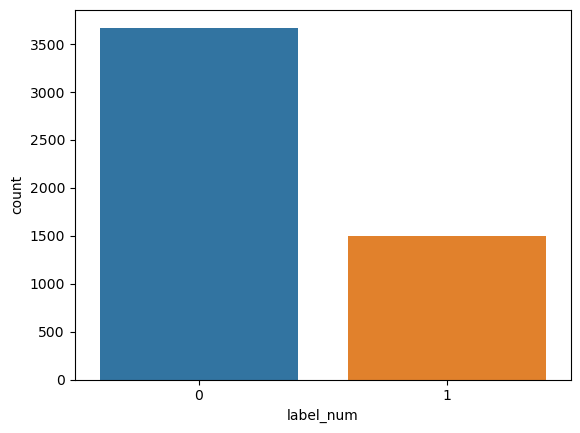

In [59]:
sns.countplot(x="label_num",data=data)
plt.show()

In [60]:
data.isnull().sum()
data_cleaned = data.dropna()

In [61]:
data.duplicated().sum()
data.drop_duplicates()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


Text(0.5, 1.0, 'Distribution of Ham and Spam email messages')

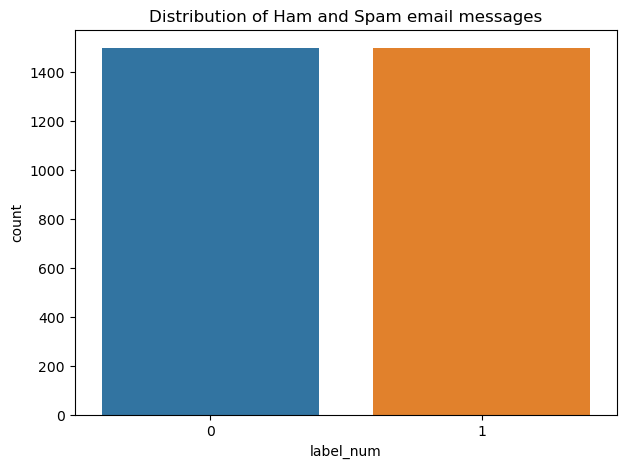

In [62]:
ham_msg = data[data.label_num == 0]
spam_msg = data[data.label_num == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),random_state=42)
balanced_data = pd.concat([ham_msg,spam_msg])
plt.figure(figsize=(7, 5))
sns.countplot(data = balanced_data, x='label_num')
plt.title('Distribution of Ham and Spam email messages')

In [63]:
balanced_data['text']=balanced_data['text'].str.replace('Subject','')
balanced_data.head()

,Unnamed: 0,label,text,label_num
2977,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
3822,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2257,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
2786,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4551,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [64]:
punctuations_list=string.punctuation
def remove_punctuation(text):
    temp=str.maketrans('','',punctuations_list)
    return text.translate(temp)

balanced_data['text']=balanced_data['text'].apply(lambda x: remove_punctuation(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
2977,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
3822,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2257,2711,ham,california energy crisis\r\ncalifornia  s p...,0
2786,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4551,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [65]:
def remove_stopword(text):
    stop_words=stopwords.words('english')

    imp_words=[]

    # storing the important words
    for word in str(text).split():
        word=word.lower()

        if word not in stop_words:
            imp_words.append(word)
        
    output=" ".join(imp_words)

    return output

balanced_data['text']=balanced_data['text'].apply(lambda text: remove_stopword(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
2977,3444,ham,conoco big cowboy darren sure help know else a...,0
3822,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2257,2711,ham,california energy crisis california  power cr...,0
2786,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4551,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


In [66]:
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],balanced_data['label_num'],test_size = 0.2,
                                                    random_state = 42)


In [67]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)
max_len = 100 # maximum  length(sequence)
train_sequences = pad_sequences(train_sequences,maxlen=max_len,padding='post',truncating='post')
test_sequences = pad_sequences(test_sequences,maxlen=max_len,padding='post',truncating='post')

In [68]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,output_dim=32,input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu')) #relu is rectified linear activation unit
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           1274912   
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1278625 (4.88 MB)
Trainable params: 1278625 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'],optimizer='adam')

In [70]:
es=EarlyStopping(patience=3,monitor='val_accuracy',restore_best_weights=True)
lr=ReduceLROnPlateau(patience=2,monitor='val_loss',factor=0.5,verbose=0)

In [71]:
history=model.fit(train_sequences,train_Y,validation_data=(test_sequences,test_Y),epochs=20,batch_size=32,callbacks=[es,lr])

Epoch 1/20
75/75 [==============================] - 12s 75ms/step - loss: 0.6372 - accuracy: 0.6130 - val_loss: 0.2989 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 4s 59ms/step - loss: 0.3748 - accuracy: 0.8953 - val_loss: 0.3150 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 5s 62ms/step - loss: 0.2386 - accuracy: 0.9258 - val_loss: 0.2996 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 5s 61ms/step - loss: 0.1804 - accuracy: 0.9525 - val_loss: 0.2162 - val_accuracy: 0.9617 - lr: 5.0000e-04


In [72]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 [==============================] - 0s 15ms/step - loss: 0.2989 - accuracy: 0.9700
Test Loss : 0.2989180088043213
Test Accuracy : 0.9700000286102295


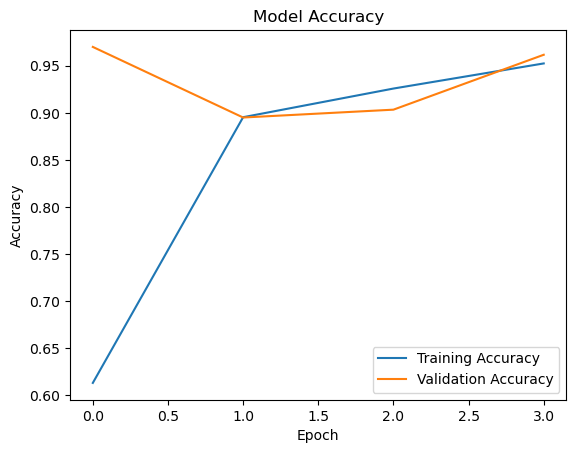

In [73]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [75]:
preds = (model.predict(test_sequences) > 0.5).astype("int32")

19/19 [==============================] - 1s 14ms/step


In [76]:
# Classification report
c_report(test_Y, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       315
           1       0.95      0.99      0.97       285

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Accuracy : 0.97


0.97